In [26]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from nltk.corpus import stopwords
nltk.download('stopwords')
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data preparation: Downloading and distributing data**

In [27]:
!mkdir -p /content/dataset/
!mkdir -p /content/pretrained_models/
!cp -v /content/drive/MyDrive/Dataset/email-spam-detection-dataset-classification/spam.csv /content/dataset/spam.csv
!cp -v /content/drive/MyDrive/Pretrained_Models/glove.6B/glove.6B.100d.txt /content/pretrained_models/glove.6B.100d.txt

'/content/drive/MyDrive/Dataset/email-spam-detection-dataset-classification/spam.csv' -> '/content/dataset/spam.csv'
'/content/drive/MyDrive/Pretrained_Models/glove.6B/glove.6B.100d.txt' -> '/content/pretrained_models/glove.6B.100d.txt'


In [28]:
# Download the dataset
path_to_dataset_file = '/content/dataset/spam.csv'
data = pd.read_csv(path_to_dataset_file, encoding='latin-1')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


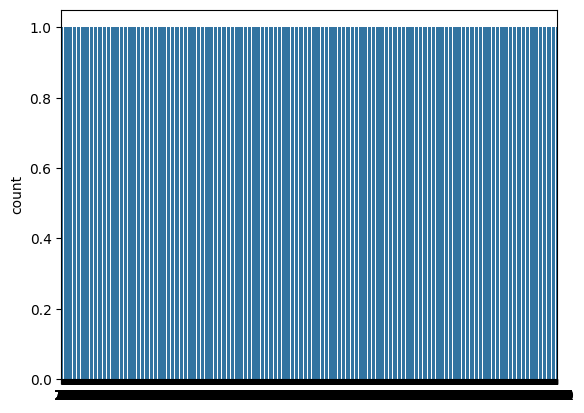

In [29]:
data = data[['v1', 'v2']]  # v1 - class (spam/ham), v2 - message text
data.columns = ['label', 'text']

# Convert the class to numeric values: spam -> 1, ham -> 0
data['label'] = data['label'].map({'spam': 1, 'ham': 0})

# Split into training and validation samples
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Estimation of the distribution of the target variable
sns.countplot(data['label'])
plt.show()

**Data preparation: Text pre-processing**

In [30]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply pre-processing
X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)

**Application of BoW and TF-IDF: BoW (Bag of Words)**

In [31]:
bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)

**Application of BoW and TF-IDF: TF-IDF (Term Frequency-Inverse Document Frequency)**

In [32]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

**Use of pre-trained embeds: Downloading an embedding model (for example, GloVe)**

In [33]:
# Download pre-trained GloVe embeddings
path_to_embeddings_file = '/content/pretrained_models/glove.6B.100d.txt'
embeddings_index = {}
with open(path_to_embeddings_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

**Use of pre-trained embeds: Convert text to embedding vectors**

In [34]:
def text_to_embedding(text):
    words = text.split()
    # Create embedding only for those words that are in the embeddings_index
    valid_embeddings = [embeddings_index.get(w, np.zeros(100)) for w in words if w in embeddings_index]

    # If there is no word with embedding, return a null vector
    if len(valid_embeddings) > 0:
        embedding = np.mean(valid_embeddings, axis=0)
    else:
        embedding = np.zeros(100)  # Return a null vector of size 100

    return embedding

X_train_embed = np.vstack([text_to_embedding(text) for text in X_train])
X_val_embed = np.vstack([text_to_embedding(text) for text in X_val])

**Building and training models: BoW-based model**

In [35]:
model_bow = LogisticRegression(max_iter=1000)
model_bow.fit(X_train_bow, y_train)
y_pred_bow = model_bow.predict(X_val_bow)

**Building and training models: Model based on TF-IDF**

In [36]:
model_tfidf = RandomForestClassifier(n_estimators=100)
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_val_tfidf)

**Building and training models: Model with embeddings**

In [37]:
model_embed = LogisticRegression(max_iter=1000)
model_embed.fit(X_train_embed, y_train)
y_pred_embed = model_embed.predict(X_val_embed)

**Evaluation of models: Performance metrics**

In [38]:
# Score for BoW
print("BoW Accuracy:", accuracy_score(y_val, y_pred_bow))
print("BoW AUC:", roc_auc_score(y_val, y_pred_bow))

# Score for TF-IDF
print("TF-IDF Accuracy:", accuracy_score(y_val, y_pred_tfidf))
print("TF-IDF AUC:", roc_auc_score(y_val, y_pred_tfidf))

# Score for embeddeds
print("Embeddings Accuracy:", accuracy_score(y_val, y_pred_embed))
print("Embeddings AUC:", roc_auc_score(y_val, y_pred_embed))

BoW Accuracy: 0.9757847533632287
BoW AUC: 0.9099999999999999
TF-IDF Accuracy: 0.9748878923766816
TF-IDF AUC: 0.9066666666666667
Embeddings Accuracy: 0.9345291479820628
Embeddings AUC: 0.838307426597582


**Порівняння результатів моделей**

*Accuracy:*

- Bag of Words (BoW) і TF-IDF показали дуже близькі результати з високою точністю. Обидві моделі мають точність близько 97.5%, що свідчить про їхню здатність добре класифікувати електронні листи на спам та легітимні повідомлення.

- Модель на основі ембедингів (GloVe) показала дещо нижчу точність — 93.45%. Це свідчить про те, що в контексті цього набору даних попередньо навчені ембедінги не дають такої ж точності, як методи на основі підрахунку слів (BoW і TF-IDF).

*AUC (Area Under the Curve):*

- BoW також демонструє трохи кращий результат за метрикою AUC (0.9100) у порівнянні з TF-IDF (0.9067). AUC вказує на здатність моделі розрізняти між класами спам і легітимні повідомлення незалежно від порогового значення.

- Модель на основі ембедингів має найнижчий результат AUC (0.8383), що свідчить про меншу здатність розрізняти між класами у порівнянні з методами на основі підрахунків слів.

**Базовий аналіз результатів**

- BoW та TF-IDF показують дуже близькі результати як за точністю, так і за AUC. Ці моделі базуються на частотах слів і більш точні для цієї задачі. У класифікації спаму важливим фактором є наявність або частота ключових слів, що пояснює хорошу роботу цих моделей. BoW може бути трохи кращим, оскільки він враховує кількість слів, що має більшу вагу в контексті класифікації спаму, де певні слова зустрічаються частіше.

- Модель на основі ембедингів (GloVe) має нижчі показники як за точністю, так і за AUC. Хоча векторні представлення слів дають багатовимірне контекстуальне представлення, цей підхід може бути менш ефективним для задачі класифікації спаму, де важлива не лише семантична подібність слів, але й конкретні ключові слова. GloVe не завжди може вловити специфічні нюанси, пов’язані зі спамом, оскільки він більше фокусується на загальній семантичній структурі мови.

**Висновок**

Для задачі класифікації спаму методи BoW та TF-IDF є більш придатними через їхню здатність працювати з частотними характеристиками слів. Використання попередньо навчених ембедингів, як-от GloVe, може бути менш ефективним для такої специфічної задачі, де ключові слова мають більший вплив на результати.